In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#now to import everyhting from classes.py and functions.py
from classes import *
from functions import *

In [6]:
print(torch.cuda.is_available()) 
print(torch.cuda.current_device())  
print(torch.cuda.get_device_name(0))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
0
NVIDIA GeForce RTX 4070 SUPER
Using device: cuda


In [7]:
# Step 1: Define Paths and Split Data
base_dir = '/Users/hunte/Desktop/PetImages'

dog_files,cat_files = gather_paths(base_dir)

train_files, train_labels, val_files, val_labels = create_train_val_split(dog_files, cat_files, val_size=0.2)

c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [8]:
# Data Augmentation and Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.7, 1.3)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Datasets and DataLoaders (see classes.py for PetDataset class)
train_dataset = PetDataset(train_files, train_labels, transform=train_transforms)
val_dataset = PetDataset(val_files, val_labels, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [9]:
# Step 3: Define CNN Model (see classes.py)
model = PetCNN().to(device)
print(model)

PetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featu

In [6]:
# Train the model
history = train_model(model, train_loader, val_loader)

Entering training loop...


Epoch 1/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.48it/s, loss=0.397, batch_acc=0.75] 


Epoch 1/20, Train Acc: 0.6507, Val Acc: 0.7424, Train Loss: 0.6303, Val Loss: 0.5078


Epoch 2/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.54it/s, loss=0.813, batch_acc=0.5]  


Epoch 2/20, Train Acc: 0.7374, Val Acc: 0.7430, Train Loss: 0.5261, Val Loss: 0.5103


Epoch 3/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.80it/s, loss=0.122, batch_acc=1]     


Epoch 3/20, Train Acc: 0.7831, Val Acc: 0.7986, Train Loss: 0.4614, Val Loss: 0.4379


Epoch 4/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.74it/s, loss=0.733, batch_acc=0.625]


Epoch 4/20, Train Acc: 0.8128, Val Acc: 0.7656, Train Loss: 0.4175, Val Loss: 0.4886


Epoch 5/20 [Val]: 100%|██████████| 157/157 [00:08<00:00, 18.17it/s, loss=0.824, batch_acc=0.75] 


Epoch 5/20, Train Acc: 0.8269, Val Acc: 0.7964, Train Loss: 0.3887, Val Loss: 0.4572


Epoch 6/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.56it/s, loss=0.635, batch_acc=0.75] 


Epoch 6/20, Train Acc: 0.8368, Val Acc: 0.8230, Train Loss: 0.3648, Val Loss: 0.4023


Epoch 7/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.73it/s, loss=0.535, batch_acc=0.75] 


Epoch 7/20, Train Acc: 0.8465, Val Acc: 0.8384, Train Loss: 0.3484, Val Loss: 0.3556


Epoch 8/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.66it/s, loss=0.327, batch_acc=0.75] 


Epoch 8/20, Train Acc: 0.8564, Val Acc: 0.8922, Train Loss: 0.3311, Val Loss: 0.2599


Epoch 9/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.69it/s, loss=0.235, batch_acc=0.875]


Epoch 9/20, Train Acc: 0.8623, Val Acc: 0.9044, Train Loss: 0.3159, Val Loss: 0.2316


Epoch 10/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.71it/s, loss=0.0898, batch_acc=1]   


Epoch 10/20, Train Acc: 0.8694, Val Acc: 0.9084, Train Loss: 0.3035, Val Loss: 0.2221


Epoch 11/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.74it/s, loss=0.271, batch_acc=0.875]


Epoch 11/20, Train Acc: 0.8717, Val Acc: 0.8668, Train Loss: 0.2941, Val Loss: 0.3091


Epoch 12/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.59it/s, loss=0.0165, batch_acc=1]    


Epoch 12/20, Train Acc: 0.8788, Val Acc: 0.8562, Train Loss: 0.2818, Val Loss: 0.3362


Epoch 13/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.63it/s, loss=0.159, batch_acc=0.875] 


Epoch 13/20, Train Acc: 0.8804, Val Acc: 0.9160, Train Loss: 0.2779, Val Loss: 0.2059


Epoch 14/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.60it/s, loss=0.0964, batch_acc=1]   


Epoch 14/20, Train Acc: 0.8884, Val Acc: 0.9050, Train Loss: 0.2659, Val Loss: 0.2408


Epoch 15/20 [Val]: 100%|██████████| 157/157 [09:31<00:00,  3.64s/it, loss=0.0577, batch_acc=1]    


Epoch 15/20, Train Acc: 0.8938, Val Acc: 0.9042, Train Loss: 0.2566, Val Loss: 0.2398


Epoch 16/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 17.15it/s, loss=0.0748, batch_acc=1]    


Epoch 16/20, Train Acc: 0.8940, Val Acc: 0.9258, Train Loss: 0.2516, Val Loss: 0.1836


Epoch 17/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.26it/s, loss=0.171, batch_acc=0.875]


Epoch 17/20, Train Acc: 0.8996, Val Acc: 0.8976, Train Loss: 0.2443, Val Loss: 0.2598


Epoch 18/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.27it/s, loss=0.0659, batch_acc=1]    


Epoch 18/20, Train Acc: 0.9006, Val Acc: 0.9338, Train Loss: 0.2386, Val Loss: 0.1636


Epoch 19/20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.06it/s, loss=0.0243, batch_acc=1]    


Epoch 19/20, Train Acc: 0.9057, Val Acc: 0.9308, Train Loss: 0.2279, Val Loss: 0.1692


Epoch 20/20 [Val]: 100%|██████████| 157/157 [00:10<00:00, 15.60it/s, loss=0.0198, batch_acc=1]    

Epoch 20/20, Train Acc: 0.9061, Val Acc: 0.9344, Train Loss: 0.2276, Val Loss: 0.1724


NameError: name 'history' is not defined

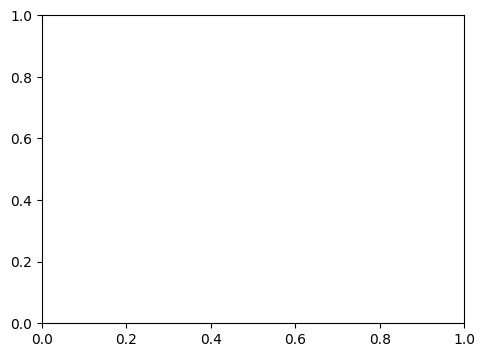

In [10]:
# Step 6: Visualize Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Bonus: Visualize Augmented Images
model.eval()
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:4].to(device), labels[:4].to(device)

plt.figure(figsize=(10, 10))
for i in range(4):
    img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
    img = img * 0.5 + 0.5  # Denormalize
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title('Cat' if labels[i].item() == 0 else 'Dog')
plt.show()

In [42]:
model.eval()
misclassified_images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        predictions = (outputs >= 0.5).float()
        incorrect = (predictions != labels)

        if incorrect.any():
            misclassified_images.extend(inputs[incorrect].cpu())
            true_labels.extend(labels[incorrect].cpu())
            pred_labels.extend(predictions[incorrect].cpu())

        if len(misclassified_images) >= 8:  # limit for visualization
            break

# Visualize misclassified images
plt.figure(figsize=(12, 8))
for i in range(min(8, len(misclassified_images))):
    img = misclassified_images[i].numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # Denormalize
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {'Cat' if true_labels[i]==0 else 'Dog'}\nPred: {'Cat' if pred_labels[i]==0 else 'Dog'}",
              color='red')
plt.tight_layout()
plt.show()


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

In [3]:
# Initialize your model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetCNN().to(device)

# Load the saved state_dict
model.load_state_dict(torch.load('best_model.pt', map_location=device))

# Put model in evaluation mode
model.eval()

PetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featu